In [1]:
# keras.backend.clear_session()
!pip install -U git+https://github.com/qubvel/efficientnet
import efficientnet.keras as efn 

from __future__ import absolute_import, division, print_function, unicode_literals
import datetime

import keras
from keras import backend as K
from keras import optimizers
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,Conv2D,Input
from keras.layers.core import Activation, Dense, Flatten,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import os.path
import shutil 
from google.colab import drive
import tensorboardcolab as tbc
%load_ext tensorboard
drive.mount('/content/gdrive',force_remount=True)

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-if_npziq
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-if_npziq
  Created wheel for efficientnet: filename=efficientnet-1.0.0b3-cp36-none-any.whl size=17630 sha256=1a5d56fc7abb6906a6f761f3a37c478da75e7dcd96ccce0df7f3e95a2cc69705
  Stored in directory: /tmp/pip-ephem-wheel-cache-xk1zptlw/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
train_dir ='/content/gdrive/My Drive/MScthesis/train/'
validation_dir = '/content/gdrive/My Drive/MScthesis/validation/'

# Directory with our training residential pictures
train_residential_dir = os.path.join(train_dir, 'residential')
print ('Total training residential images:', len(os.listdir(train_residential_dir)))

# Directory with our training non-residential pictures
train_nonresidential_dir = os.path.join(train_dir, 'nonresidential')
print ('Total training non-residential images:', len(os.listdir(train_nonresidential_dir)))

# Directory with our validation residential pictures
validation_residential_dir = os.path.join(validation_dir, 'residential')
print ('Total validation residential images:', len(os.listdir(validation_residential_dir)))

# Directory with our validation non-residential pictures
validation_nonresidential_dir = os.path.join(validation_dir, 'nonresidential')
print ('Total validation non-residential images:', len(os.listdir(validation_nonresidential_dir)))

'''
Originally, there are around 
5900 train residential images
770 train non-residential images  
545 validation residential images
120 validation non-residential images
So random guess on validation set accuracy should be 81.9% 
Total test non-residential images: 180
Total test residential images: 504
So random guess on test set accuracy should be 73.6%
'''

Total training residential images: 7357
Total training non-residential images: 3803
Total validation residential images: 681
Total validation non-residential images: 551


'\nOriginally, there are around \n5900 train residential images\n770 train non-residential images  \n545 validation residential images\n120 validation non-residential images\nSo random guess on validation set accuracy should be 81.9% \nTotal test non-residential images: 180\nTotal test residential images: 504\nSo random guess on test set accuracy should be 73.6%\n'

In [4]:
batch_size = 64
image_size = 160
# Rescale all images by 1./255 and apply image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                  # rotation_range=3,
                  # shear_range=0.2,
                  # zoom_range=0.2,
                  # fill_mode='nearest',
                  # width_shift_range=0.1,
                  # horizontal_flip=True,
                  # height_shift_range=0.1,
                                  )

validation_datagen = ImageDataGenerator(rescale=1./255,
                    # rotation_range=3,
                    # shear_range=0.2,
                    # zoom_range=0.2,
                    # fill_mode='nearest',
                    # width_shift_range=0.1,
                    # horizontal_flip=True,
                    # height_shift_range=0.1,
                                       )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,  # Source directory for the training images
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='binary')  # Since we use binary_crossentropy loss, we need binary labels

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir, # Source directory for the validation images
                                                              target_size=(image_size, image_size),
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              class_mode='binary')

Found 11160 images belonging to 2 classes.
Found 1232 images belonging to 2 classes.


In [5]:
IMG_SHAPE = (image_size, image_size, 3)
# Create the base model from the pre-trained model EfficientNet-B7
base_model = efn.EfficientNetB7(input_shape=IMG_SHAPE,
                                include_top=False,
                                weights='imagenet')

W0906 14:39:23.511636 140004315789184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 14:39:23.559433 140004315789184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 14:39:23.568977 140004315789184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0906 14:39:23.603376 140004315789184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0906 14:39:23.605497

258441216/258434480 [==============================] - 8s 0us/step


In [0]:
# base_model.trainable = False
# base_model.summary()

In [0]:
import tensorflow as tf
#recall
# def recall_m(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         recall = true_positives / (possible_positives + K.epsilon())
#         return recall

# #precision
# def precision_m(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#         precision = true_positives / (predicted_positives + K.epsilon())
#         return precision

# #f1_score
# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

#focal loss
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed



In [0]:
# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
EARLY_STOP_PATIENCE = 5
# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)

## LR finder

In [0]:
from keras.callbacks import Callback
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

## add classification head

In [0]:
dropout_rate = 0.5
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(256,activation='relu',name='fc1'),
  Dropout(rate = dropout_rate, name="dropout_out"),
  Dense(1, activation='sigmoid',name='predictions')
])

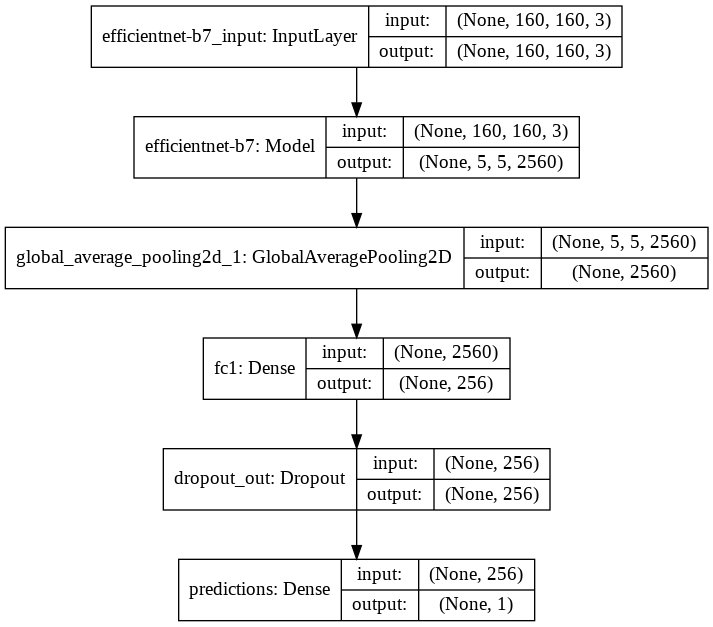

In [7]:
from keras.utils import plot_model
plot_model(model, show_shapes=True,to_file='/content/models.png')

In [0]:
model.compile(optimizers.SGD(lr=1e-3, decay=1e-5, momentum=0.9, nesterov=True),
#     optimizers.adam(lr=5e-4),
#     optimizer=optimizers.SGD(lr=1e-3, decay=1e-5, momentum=0.9, nesterov=True),
#               loss=[focal_loss(alpha=.25, gamma=2)],
            loss='binary_crossentropy',
            metrics=['acc'])
model.summary()

W0829 08:36:59.870680 139698953435008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0829 08:36:59.885616 139698953435008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 5, 5, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               655616    
_________________________________________________________________
dropout_out (Dropout)        (None, 256)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 257       
Total params: 64,753,553
Trainable params: 59,738,905
Non-trainable params: 5,014,648
_________________________________________________________________


In [0]:
epochs = 5
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[cb_early_stopper])

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [0]:
acc += history.history['acc']
val_acc += history.history['val_acc']

loss += history.history['loss']
val_loss += history.history['val_loss']

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

Fine-tuning

In [0]:
base_model.trainable = True
set_trainable = False
# for layer in base_model.layers:
#     if layer.name == 'multiply_16':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [0]:
# Check how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  806


In [0]:
# Fine tune from this layer onwards
fine_tune_at = 403

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
!mkdir models

In [0]:
EARLY_STOP_PATIENCE = 5
import tensorboardcolab as tbc
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, restore_best_weights=True)
cb_checkpointer  = ModelCheckpoint(filepath = '/content/models/EfficientNetB7-{val_loss:.4f}-{val_acc:.4f}.h5', monitor = 'val_acc', save_best_only = True, mode = 'auto')

In [0]:
model.compile(optimizer = optimizers.adam(lr=2e-5),
              # optimizers.SGD(lr=5e-4, decay=1e-6, momentum=0.9, nesterov=True)
              loss='binary_crossentropy',
              metrics=['acc'])
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard= keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.summary()

In [0]:
len(model.trainable_weights)

359

In [0]:
# tbc.TensorBoardColab(graph_path=logdir);

In [0]:
# %tensorboard --logdir logs

In [0]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
history_fine = model.fit_generator(train_generator,
                  steps_per_epoch = steps_per_epoch,
                  epochs=30,
                  workers=4,
                  validation_data=validation_generator,
                  validation_steps=validation_steps,
                  callbacks=[cb_checkpointer,cb_early_stopper])

Epoch 1/30
174/174 [==============================] - 1395s 8s/step - loss: 0.6613 - acc: 0.6161 - val_loss: 0.6728 - val_acc: 0.5477
Epoch 2/30
174/174 [==============================] - 360s 2s/step - loss: 0.6180 - acc: 0.6715 - val_loss: 0.6557 - val_acc: 0.5479
Epoch 3/30
174/174 [==============================] - 357s 2s/step - loss: 0.5914 - acc: 0.6912 - val_loss: 0.6159 - val_acc: 0.5899
Epoch 4/30
174/174 [==============================] - 357s 2s/step - loss: 0.5630 - acc: 0.7144 - val_loss: 0.5791 - val_acc: 0.6678
Epoch 5/30
174/174 [==============================] - 357s 2s/step - loss: 0.5324 - acc: 0.7404 - val_loss: 0.5520 - val_acc: 0.6969
Epoch 6/30
174/174 [==============================] - 357s 2s/step - loss: 0.4999 - acc: 0.7629 - val_loss: 0.5108 - val_acc: 0.7440
Epoch 7/30
174/174 [==============================] - 357s 2s/step - loss: 0.4722 - acc: 0.7892 - val_loss: 0.4858 - val_acc: 0.7748
Epoch 8/30
174/174 [==============================] - 357s 2s/step -

In [0]:
acc = history_fine.history['acc']
val_acc = history_fine.history['val_acc']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

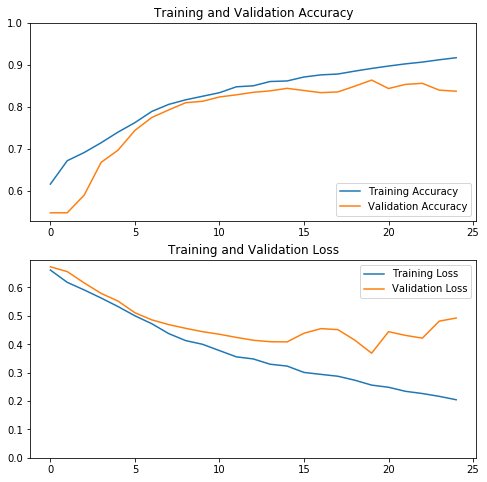

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
# plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,max(plt.ylim())])
# plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## plot confusion matrix

In [0]:
model.trainable = False
set_trainable = False

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
#Confution Matrix and Classification Report
# threshold = 0.60
batch_size=16
Y_pred = model.predict_generator(test_gen, test_gen.n // batch_size+1,workers=4,verbose=1).ravel()
# y_pred = np.where(Y_pred > threshold, 1,0)
target_names = ['nonresidential','residential']
# print(classification_report(validation_generator.classes, Y_pred, target_names=target_names))

40/40 [==============================] - 17s 437ms/step


In [0]:
from sklearn.metrics import classification_report, confusion_matrix
from numpy import *
random.seed(5)
import seaborn as sns
#Confution Matrix and Classification Report
threshold = 0.50
batch_size= 16
Y_pred = model.predict_generator(test_gen, test_gen.n // batch_size+1,workers = 4,verbose=1)
y_pred = np.where(Y_pred > threshold, 1,0)
print('Classification Report')
target_names = ['nonresidential','residential']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

40/40 [==============================] - 12s 295ms/step
Classification Report
                precision    recall  f1-score   support

nonresidential       0.67      0.54      0.60       156
   residential       0.86      0.91      0.88       471

      accuracy                           0.82       627
     macro avg       0.76      0.72      0.74       627
  weighted avg       0.81      0.82      0.81       627



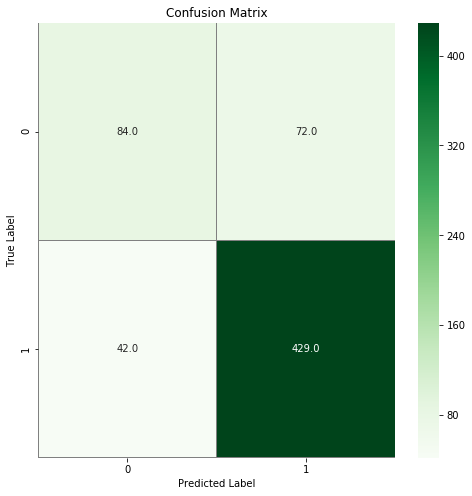

In [0]:
confusion_mtx = confusion_matrix(test_gen.classes, y_pred) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [0]:
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve,f1_score,average_precision_score
from matplotlib import pyplot as plt
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, Y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

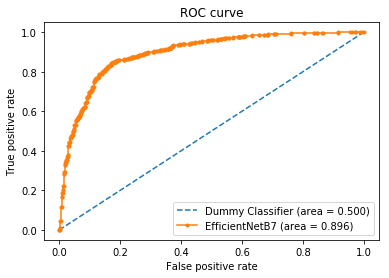

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], linestyle='--',label='Dummy Classifier (area = 0.500)')
plt.plot(fpr_keras, tpr_keras, label='EfficientNetB7 (area = {:.3f})'.format(auc_keras),marker='.')
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_gen.classes, Y_pred)
# calculate F1 score
f1 = f1_score(test_gen.classes, y_pred)
# calculate precision-recall AUC
rp_auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_gen.classes, Y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, rp_auc, ap))

f1=0.883 auc=0.932 ap=0.932


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.93')

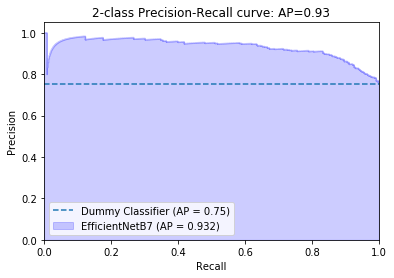

In [0]:
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve,f1_score,average_precision_score
from matplotlib import pyplot as plt
precision, recall, _ = precision_recall_curve(test_gen.classes, Y_pred)
average_precision = average_precision_score(test_gen.classes, Y_pred)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b',label='EfficientNetB7 (AP = {:.3f})'.format(average_precision))
plt.plot([0, 1], [0.75,0.75], linestyle='--',label='Dummy Classifier (AP = 0.75)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

Save the model

In [0]:
!cp -r /content/models gdrive/My\ Drive/MScthesis

load the model, rerun the model with weight

In [0]:
model.load_weights('/content/gdrive/My Drive/MScthesis/MobileNetV2.0.3666-0.8656.h5')
# model.compile(optimizer = keras.optimizers.Adam(lr=1e-5),
#               loss='binary_crossentropy',
#               metrics=['acc',f1_m,precision_m, recall_m])
# model.summary()

# Save the model

In [0]:
!cp -r /content/models gdrive/My\ Drive/MScthesis

In [0]:
model.save('models/keras/model.h5')

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)


## Load the model

In [0]:
from keras.models import load_model

In [0]:
model=load_model('/content/gdrive/My Drive/MScthesis/models/EfficientNetB7-0.3684-0.8639.h5')

W0830 10:47:43.924714 139851012175744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 10:47:44.067563 139851012175744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0830 10:47:44.107858 139851012175744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 10:47:44.109041 139851012175744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0830 10:47:44.111710

In [0]:
test_dir='/content/gdrive/My Drive/MScthesis/test/'
# Directory with our test non-residential pictures
test_nonresidential_dir = os.path.join(test_dir, 'nonresidential')
print ('Total test non-residential images:', len(os.listdir(test_nonresidential_dir)))

# Directory with our test residential pictures
test_residential_dir = os.path.join(test_dir, 'residential')
print ('Total test residential images:', len(os.listdir(test_residential_dir)))

Total test non-residential images: 156
Total test residential images: 471


In [0]:
image_size = 160
batch_size = 16
test_idg = ImageDataGenerator(rescale=1./255)
test_gen = test_idg.flow_from_directory(
    '/content/gdrive/My Drive/MScthesis/test/',
    target_size=(image_size, image_size),
    batch_size = batch_size,
    shuffle = False,
    class_mode='binary',
)
len(test_gen.filenames)

Found 627 images belonging to 2 classes.


627

In [0]:
test_steps = test_gen.n // batch_size
loss, acc = model.evaluate_generator(test_gen, steps = test_steps, workers = 4, verbose=1)

39/39 [==============================] - 78s 2s/step


In [0]:
acc,loss

(0.8173076923076923, 0.4805700835079337)

Make predictions on sample test images

In [0]:
validation_img_paths = ["validation/alien/11.jpg",
                        "validation/alien/22.jpg",
                        "validation/predator/33.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [0]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [0]:
pred_probs = model.predict(validation_batch)
pred_probs

In [0]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)